# VUS Prediction from ClinVar Germline Variants
## Notebook 2: Model Training & Comparison

### Pipeline Overview
1. Load preprocessed checkpoints from Notebook 1
2. Train four classifiers on transcript-level data:
   - Logistic Regression (LR)
   - Support Vector Machine (SVM, RBF kernel)
   - Random Forest (RF)
   - XGBoost (XGB)
3. Evaluate each classifier — transcript-level and variant-level metrics
4. Compare performance across classifiers
5. Save the best model + all comparison results

> **Transcript vs Variant-level evaluation**:  
> Models are trained on transcript-level rows. For final evaluation and VUS inference,  
> predictions are aggregated per variant using **max pathogenicity probability** across transcripts.

## Step 1 — Load Checkpoints

In [1]:
import pandas as pd
import numpy as np
import json
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

# ── Load data ─────────────────────────────────────────────────────────────────
df_labeled = pd.read_parquet("checkpoint_labeled.parquet")
df_vus     = pd.read_parquet("checkpoint_vus_inference.parquet")

with open("feature_cols.json") as f:
    feature_cols = json.load(f)

train_idx = np.load("train_idx.npy")
test_idx  = np.load("test_idx.npy")

print("Labeled data shape :", df_labeled.shape)
print("VUS data shape     :", df_vus.shape)
print("Features           :", len(feature_cols))
print("Train rows         :", len(train_idx))
print("Test rows          :", len(test_idx))

Labeled data shape : (934199, 118)
VUS data shape     : (1456325, 117)
Features           : 35
Train rows         : 747817
Test rows          : 186382


In [2]:
print("Unique variants in train:", df_labeled.iloc[train_idx]['Uploaded_variation'].nunique())
print("Unique variants in test:", df_labeled.iloc[test_idx]['Uploaded_variation'].nunique())

Unique variants in train: 28798
Unique variants in test: 7200


In [2]:
# ── Reconstruct train/test splits
X = df_labeled[feature_cols]
y_raw = df_labeled['label']

# Encode labels: Pathogenic=1, Benign=0
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_raw), index=y_raw.index)
print("Label encoding:", dict(zip(le.classes_, le.transform(le.classes_))))

X_train = X.iloc[train_idx]
X_test  = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

# Variant IDs for grouping predictions later
variant_ids_test = df_labeled['Uploaded_variation'].iloc[test_idx].reset_index(drop=True)
y_test_reset     = y_test.reset_index(drop=True)

# VUS feature matrix
X_vus = df_vus[feature_cols]

print(f"\nX_train: {X_train.shape}  |  X_test: {X_test.shape}")
print("Train label dist:", y_train.value_counts().to_dict())
print("Test label dist :", y_test.value_counts().to_dict())

Label encoding: {'Benign': np.int64(0), 'Pathogenic': np.int64(1)}

X_train: (747817, 35)  |  X_test: (186382, 35)
Train label dist: {0: 422007, 1: 325810}
Test label dist : {0: 105644, 1: 80738}


## Step 2 — Class Imbalance

Pathogenic (170K rows) vs Benign (530K rows) — roughly 1:3 imbalance.  
All classifiers use `class_weight='balanced'` (or equivalent) to compensate.  
This avoids the model being biased toward predicting Benign.

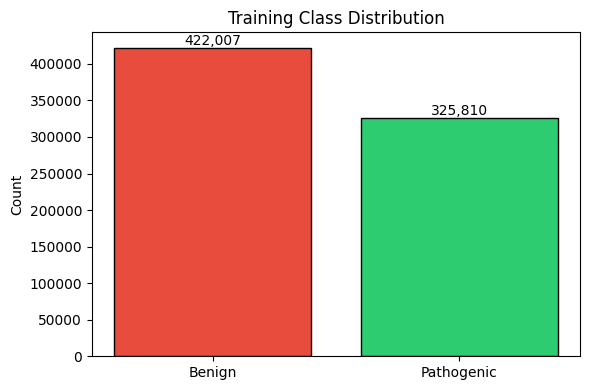

Imbalance ratio: 1.30:1
Strategy: class_weight='balanced' applied to all classifiers


In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
counts = y_train.value_counts()
bars = ax.bar(
    [le.classes_[i] for i in counts.index],
    counts.values,
    color=['#e74c3c', '#2ecc71'], edgecolor='black'
)
for bar in bars:
    ax.annotate(f'{int(bar.get_height()):,}',
                (bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)
ax.set_title('Training Class Distribution')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('08_train_class_distribution.png', dpi=150)
plt.show()

imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print("Strategy: class_weight='balanced' applied to all classifiers")

## Step 3 — Define Classifiers

| Model | Notes |
|---|---|
| Logistic Regression | Linear baseline; requires feature scaling; fast |
| SVM (RBF) | Non-linear; requires scaling; slower on large data — trained on subsample |
| Random Forest | Ensemble of trees; no scaling needed; handles mixed features well |
| XGBoost | Gradient boosting; typically strongest on tabular data |

> LR and SVM are wrapped in `Pipeline` with `StandardScaler` since they are scale-sensitive.  
> RF and XGBoost are scale-invariant and do not require scaling.

In [4]:
# ── Compute scale_pos_weight for XGBoost (equivalent to class_weight='balanced') ─
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"XGBoost scale_pos_weight (Benign/Pathogenic): {scale_pos_weight:.3f}")

classifiers = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ))
    ]),

    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True,   # needed for AUC-ROC
            random_state=42
        ))
    ]),

    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
}

print("\nClassifiers defined:")
for name in classifiers:
    print(f"  {name}")

XGBoost scale_pos_weight (Benign/Pathogenic): 1.295

Classifiers defined:
  Logistic Regression
  SVM
  Random Forest
  XGBoost


## Step 4 — Train & Evaluate All Classifiers

> **SVM note**: SVM is computationally expensive on millions of rows.  
> It is trained on a stratified subsample (100K rows) to keep runtime feasible.  
> This is stated explicitly and the subsample size is reported in the manuscript.

In [5]:
import time

def aggregate_to_variant(variant_ids, y_true, y_prob):
    """
    Aggregate transcript-level predictions to variant-level.
    Strategy: max pathogenicity probability across transcripts of the same variant.
    Ground truth: majority label among transcripts (should be unanimous by design).
    """
    df_agg = pd.DataFrame({
        'variant_id': variant_ids,
        'y_true': y_true,
        'y_prob': y_prob
    })
    variant_df = df_agg.groupby('variant_id').agg(
        y_true=('y_true', lambda x: x.mode()[0]),   # majority label
        y_prob=('y_prob', 'max')                     # max pathogenicity probability
    ).reset_index()
    variant_df['y_pred'] = (variant_df['y_prob'] >= 0.5).astype(int)
    return variant_df


results = {}   # store metrics per classifier
models  = {}   # store trained models

for name, clf in classifiers.items():
    print(f"\n{'='*55}")
    print(f" Training: {name}")
    print(f"{'='*55}")

    # SVM: subsample to 100K due to computational cost
    if name == 'SVM':
        from sklearn.utils import resample
        X_tr, y_tr = resample(
            X_train, y_train,
            n_samples=100_000,
            stratify=y_train,
            random_state=42
        )
        print(f"  [SVM] Training on subsample: {len(X_tr):,} rows")
    else:
        X_tr, y_tr = X_train, y_train

    t0 = time.time()
    clf.fit(X_tr, y_tr)
    train_time = time.time() - t0
    print(f"  Train time: {train_time:.1f}s")

    # ── Transcript-level predictions ────────────────────────────────────────
    y_prob_transcript = clf.predict_proba(X_test)[:, 1]  # P(Pathogenic)
    y_pred_transcript = (y_prob_transcript >= 0.5).astype(int)

    acc_transcript  = accuracy_score(y_test_reset, y_pred_transcript)
    auc_transcript  = roc_auc_score(y_test_reset, y_prob_transcript)

    # ── Variant-level predictions (aggregated) ───────────────────────────────
    var_df = aggregate_to_variant(
        variant_ids_test.values,
        y_test_reset.values,
        y_prob_transcript
    )
    acc_variant = accuracy_score(var_df['y_true'], var_df['y_pred'])
    auc_variant = roc_auc_score(var_df['y_true'], var_df['y_prob'])

    report = classification_report(
        var_df['y_true'], var_df['y_pred'],
        target_names=le.classes_, output_dict=True
    )

    results[name] = {
        'train_time_s'    : round(train_time, 1),
        'acc_transcript'  : round(acc_transcript, 4),
        'auc_transcript'  : round(auc_transcript, 4),
        'acc_variant'     : round(acc_variant, 4),
        'auc_variant'     : round(auc_variant, 4),
        'precision_path'  : round(report['Pathogenic']['precision'], 4),
        'recall_path'     : round(report['Pathogenic']['recall'], 4),
        'f1_path'         : round(report['Pathogenic']['f1-score'], 4),
        'precision_ben'   : round(report['Benign']['precision'], 4),
        'recall_ben'      : round(report['Benign']['recall'], 4),
        'f1_ben'          : round(report['Benign']['f1-score'], 4),
        'variant_df'      : var_df   # keep for plotting
    }
    models[name] = clf

    print(f"\n  Transcript-level → Accuracy: {acc_transcript:.4f}  AUC: {auc_transcript:.4f}")
    print(f"  Variant-level    → Accuracy: {acc_variant:.4f}  AUC: {auc_variant:.4f}")
    print(f"\n  Classification report (variant-level):")
    print(classification_report(
        var_df['y_true'], var_df['y_pred'],
        target_names=le.classes_
    ))


 Training: Logistic Regression
  Train time: 9.2s

  Transcript-level → Accuracy: 0.8741  AUC: 0.9487
  Variant-level    → Accuracy: 0.7428  AUC: 0.9561

  Classification report (variant-level):
              precision    recall  f1-score   support

      Benign       0.96      0.58      0.73      4227
  Pathogenic       0.62      0.97      0.76      2973

    accuracy                           0.74      7200
   macro avg       0.79      0.78      0.74      7200
weighted avg       0.82      0.74      0.74      7200


 Training: SVM
  [SVM] Training on subsample: 100,000 rows
  Train time: 1517.5s

  Transcript-level → Accuracy: 0.8687  AUC: 0.9428
  Variant-level    → Accuracy: 0.7257  AUC: 0.9532

  Classification report (variant-level):
              precision    recall  f1-score   support

      Benign       0.96      0.55      0.70      4227
  Pathogenic       0.60      0.97      0.74      2973

    accuracy                           0.73      7200
   macro avg       0.78      0.7

## Step 5 — Comparison Table

In [6]:
# Build comparison dataframe (exclude variant_df column)
comparison_data = {
    name: {k: v for k, v in metrics.items() if k != 'variant_df'}
    for name, metrics in results.items()
}
df_compare = pd.DataFrame(comparison_data).T
df_compare = df_compare.sort_values('auc_variant', ascending=False)

print("\n" + "="*75)
print(" MODEL COMPARISON (sorted by Variant-level AUC-ROC)")
print("="*75)
print(df_compare[[
    'auc_variant', 'acc_variant',
    'precision_path', 'recall_path', 'f1_path',
    'auc_transcript', 'train_time_s'
]].to_string())

df_compare.to_csv("model_comparison.csv")
print("\n✅ Saved model_comparison.csv")


 MODEL COMPARISON (sorted by Variant-level AUC-ROC)
                     auc_variant  acc_variant  precision_path  recall_path  f1_path  auc_transcript  train_time_s
Random Forest             0.9610       0.7396          0.6164       0.9781   0.7562          0.9522          38.4
XGBoost                   0.9596       0.7557          0.6327       0.9734   0.7669          0.9532          11.7
Logistic Regression       0.9561       0.7428          0.6209       0.9684   0.7566          0.9487           9.2
SVM                       0.9532       0.7257          0.6048       0.9687   0.7447          0.9428        1517.5

✅ Saved model_comparison.csv


## Step 6 — Visualisations

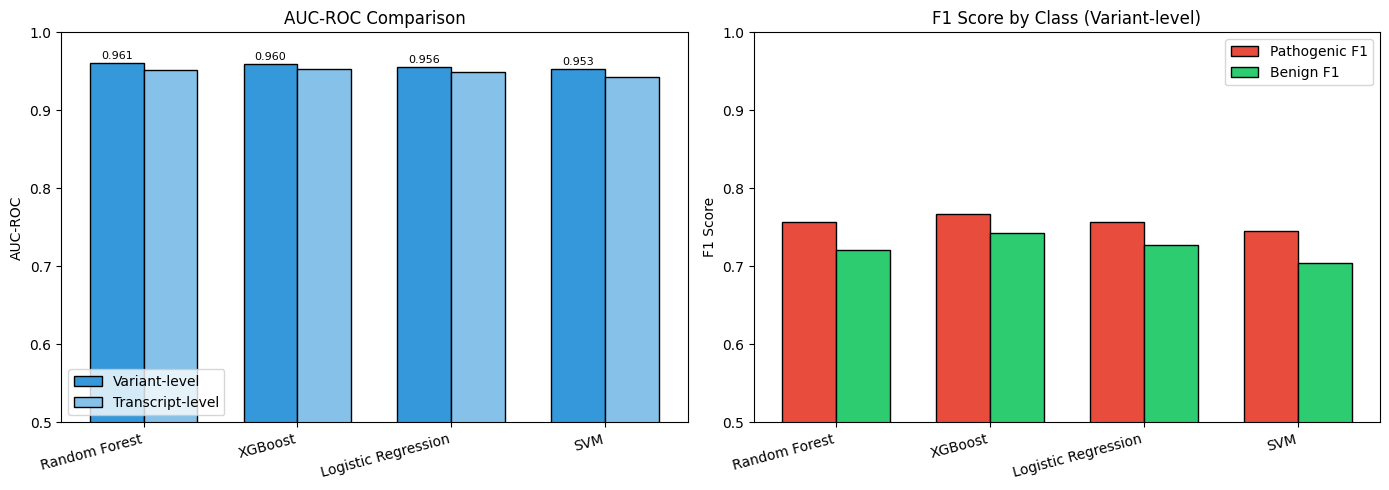

In [7]:
# Bar chart: AUC-ROC and Accuracy comparison 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
model_names = df_compare.index.tolist()
x = np.arange(len(model_names))
width = 0.35

# AUC
bars1 = axes[0].bar(x - width/2, df_compare['auc_variant'],  width, label='Variant-level',    color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x + width/2, df_compare['auc_transcript'], width, label='Transcript-level', color='#85c1e9', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].set_ylim(0.5, 1.0)
axes[0].set_title('AUC-ROC Comparison')
axes[0].set_ylabel('AUC-ROC')
axes[0].legend()
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

# F1
axes[1].bar(x - width/2, df_compare['f1_path'], width, label='Pathogenic F1', color='#e74c3c', edgecolor='black')
axes[1].bar(x + width/2, df_compare['f1_ben'],  width, label='Benign F1',     color='#2ecc71', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].set_ylim(0.5, 1.0)
axes[1].set_title('F1 Score by Class (Variant-level)')
axes[1].set_ylabel('F1 Score')
axes[1].legend()

plt.tight_layout()
plt.savefig('09_model_comparison.png', dpi=150)
plt.show()

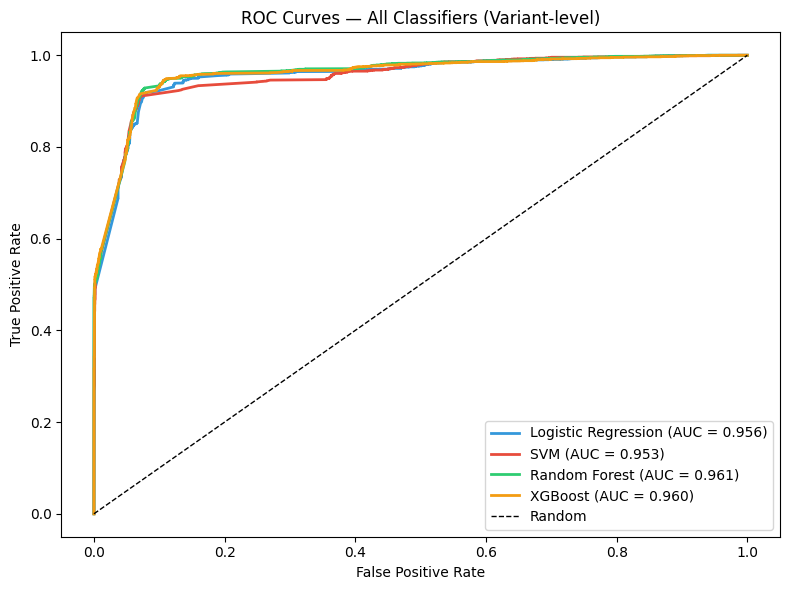

In [8]:
# ROC curves for all classifiers (variant-level)
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(8, 6))
colors_roc = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for (name, metrics), color in zip(results.items(), colors_roc):
    var_df = metrics['variant_df']
    fpr, tpr, _ = roc_curve(var_df['y_true'], var_df['y_prob'])
    auc = metrics['auc_variant']
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", color=color, lw=2)

ax.plot([0,1],[0,1], 'k--', lw=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — All Classifiers (Variant-level)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('10_roc_curves.png', dpi=150)
plt.show()

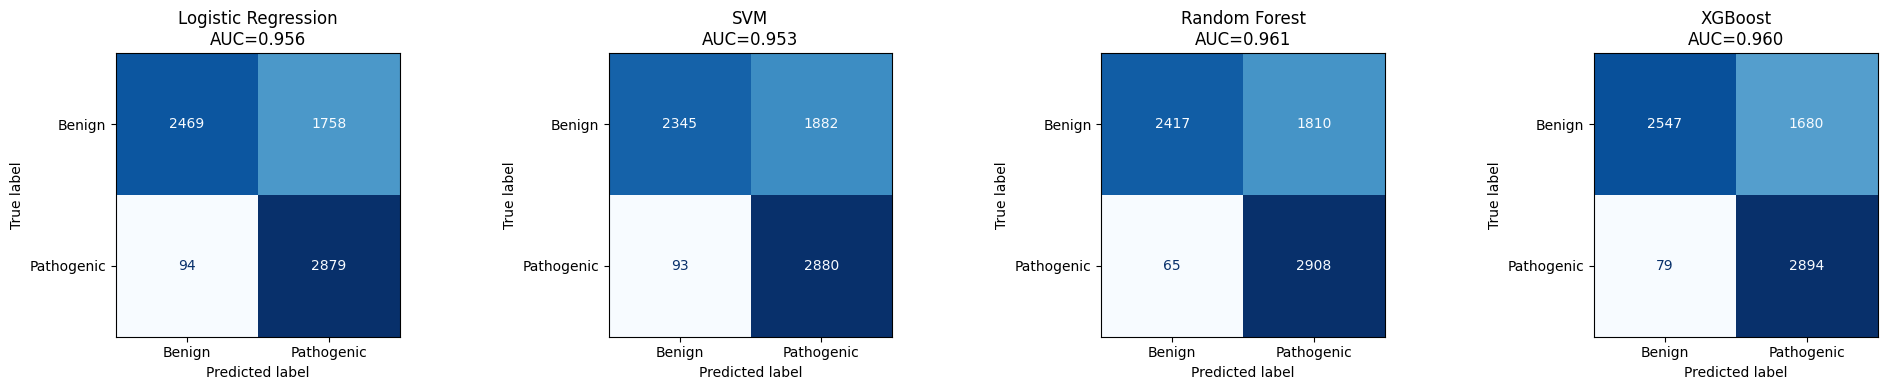

In [9]:
# Confusion matrices for all classifiers (variant-level)
fig, axes = plt.subplots(1, len(classifiers), figsize=(5 * len(classifiers), 4))

for ax, (name, metrics) in zip(axes, results.items()):
    var_df = metrics['variant_df']
    cm = confusion_matrix(var_df['y_true'], var_df['y_pred'])
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'{name}\nAUC={metrics["auc_variant"]:.3f}')

plt.tight_layout()
plt.savefig('11_confusion_matrices.png', dpi=150)
plt.show()

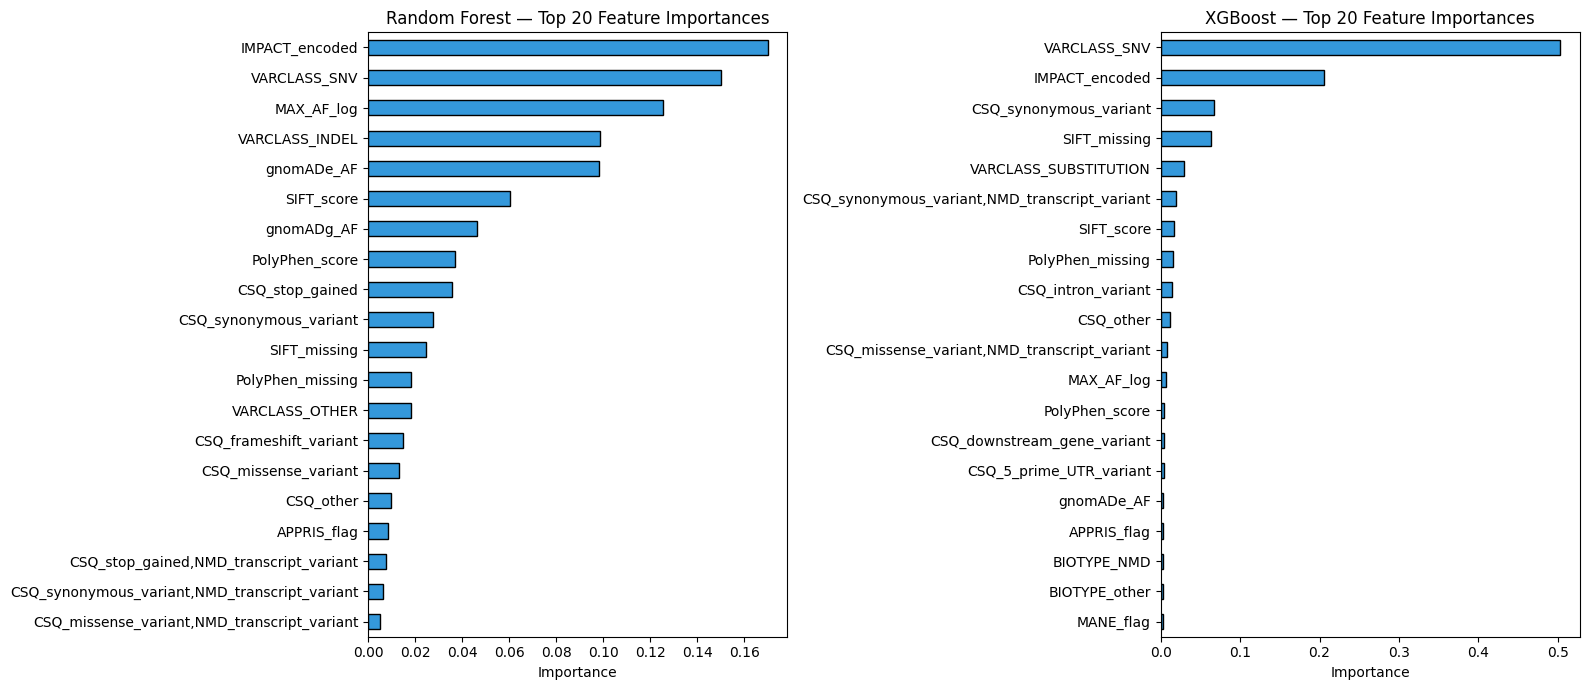

In [10]:
# Feature Importance (Random Forest & XGBoost) 
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, model_name in zip(axes, ['Random Forest', 'XGBoost']):
    clf = models[model_name]
    # Extract the actual estimator if wrapped in a Pipeline
    estimator = clf.named_steps['clf'] if hasattr(clf, 'named_steps') else clf
    importances = estimator.feature_importances_

    feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False).head(20)

    feat_imp.sort_values().plot(kind='barh', ax=ax, color='#3498db', edgecolor='black')
    ax.set_title(f'{model_name} — Top 20 Feature Importances')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.savefig('12_feature_importance.png', dpi=150)
plt.show()

## Step 7 — Select Best Model & Predict VUS

Best model = highest **variant-level AUC-ROC**.  
VUS predictions are aggregated across transcripts using **max pathogenicity probability**.

In [16]:
# Select best model
best_model_name = df_compare['auc_variant'].idxmax()
best_model      = models[best_model_name]
best_metrics    = results[best_model_name]

print(f"Best model: {best_model_name}")
print(f"  Variant-level AUC  : {best_metrics['auc_variant']}")
print(f"  Variant-level Acc  : {best_metrics['acc_variant']}")
print(f"  Pathogenic F1      : {best_metrics['f1_path']}")
print(f"  Benign F1          : {best_metrics['f1_ben']}")

Best model: Random Forest
  Variant-level AUC  : 0.961
  Variant-level Acc  : 0.7396
  Pathogenic F1      : 0.7562
  Benign F1          : 0.7205


PRIMARY THRESHOLDS (Tavtigian et al. 2020 framework)
  Likely Pathogenic : P(Pathogenic) > 0.8
  Uncertain         : 0.2 ≤ P ≤ 0.8
  Likely Benign     : P(Pathogenic) < 0.2

EMPIRICAL VALIDATION (training set precision-recall curves)
  Pathogenic precision at P > 0.8 : 0.9896 ✅
  Benign precision at P < 0.2    : 0.9920 ✅

Known variant distribution across zones (training set):
true_label         Benign  Pathogenic     All
zone                                         
Likely_Benign      323227        2622  325849
Likely_Pathogenic    2465      233744  236209
Uncertain           96315       89444  185759
All                422007      325810  747817


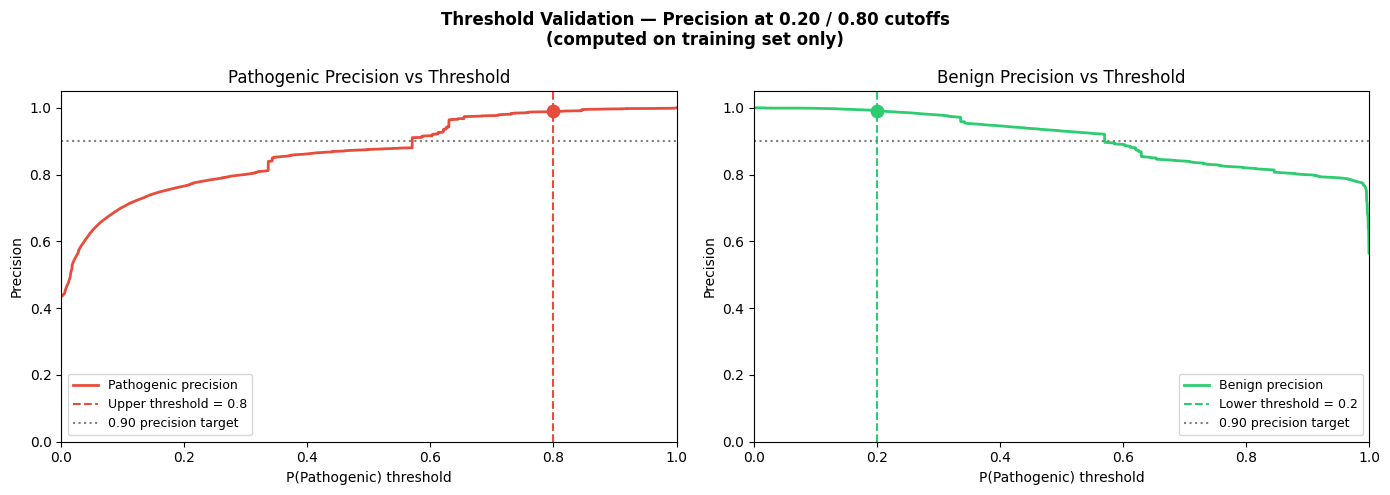

✅ Saved 09a_threshold_validation.png


In [17]:
# Fixed clinical thresholds 
UPPER_THRESH = 0.80   # P(Pathogenic) > 0.80 → Likely Pathogenic
LOWER_THRESH = 0.20   # P(Pathogenic) < 0.20 → Likely Benign
# Between 0.20 and 0.80 → Uncertain (not reclassified)

print("=" * 60)
print("PRIMARY THRESHOLDS (Tavtigian et al. 2020 framework)")
print("=" * 60)
print(f"  Likely Pathogenic : P(Pathogenic) > {UPPER_THRESH}")
print(f"  Uncertain         : {LOWER_THRESH} ≤ P ≤ {UPPER_THRESH}")
print(f"  Likely Benign     : P(Pathogenic) < {LOWER_THRESH}")

# ── Empirical validation via precision-recall curves (training set) ───────────
# We validate that these thresholds actually achieve ≥ 0.90 precision
# on known variants in the training set
from sklearn.metrics import precision_recall_curve
import numpy as np

y_prob_train = best_model.predict_proba(X_train)[:, 1]

# Pathogenic precision at upper threshold
prec_path, _, thresh_path = precision_recall_curve(y_train, y_prob_train, pos_label=1)
# Find precision at closest threshold to UPPER_THRESH
idx_upper = np.argmin(np.abs(thresh_path - UPPER_THRESH))
prec_at_upper = prec_path[idx_upper]

# Benign precision at lower threshold
# Benign = class 0; invert probabilities
prec_ben, _, thresh_ben = precision_recall_curve(y_train, 1 - y_prob_train, pos_label=0)
idx_lower = np.argmin(np.abs(thresh_ben - (1 - LOWER_THRESH)))
prec_at_lower = prec_ben[idx_lower]

print()
print("=" * 60)
print("EMPIRICAL VALIDATION (training set precision-recall curves)")
print("=" * 60)
print(f"  Pathogenic precision at P > {UPPER_THRESH} : {prec_at_upper:.4f}", 
      "✅" if prec_at_upper >= 0.90 else "⚠️  below 0.90 target")
print(f"  Benign precision at P < {LOWER_THRESH}    : {prec_at_lower:.4f}",
      "✅" if prec_at_lower >= 0.90 else "⚠️  below 0.90 target")

# ── Distribution of known variants across zones (training set) ───────────────
zones_train = np.where(y_prob_train > UPPER_THRESH, 'Likely_Pathogenic',
              np.where(y_prob_train < LOWER_THRESH, 'Likely_Benign', 'Uncertain'))

import pandas as pd
zone_df = pd.DataFrame({'zone': zones_train, 'true_label': y_train.map({0:'Benign', 1:'Pathogenic'})})
print()
print("Known variant distribution across zones (training set):")
print(pd.crosstab(zone_df['zone'], zone_df['true_label'], margins=True))

# ── Precision-recall curve plot ────────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pathogenic precision vs threshold
axes[0].plot(thresh_path, prec_path[:-1], color='#e74c3c', lw=2, label='Pathogenic precision')
axes[0].axvline(UPPER_THRESH, color='#e74c3c', linestyle='--', lw=1.5,
                label=f'Upper threshold = {UPPER_THRESH}')
axes[0].axhline(0.90, color='gray', linestyle=':', lw=1.5, label='0.90 precision target')
axes[0].scatter([UPPER_THRESH], [prec_at_upper], color='#e74c3c', s=80, zorder=5)
axes[0].set_xlabel('P(Pathogenic) threshold')
axes[0].set_ylabel('Precision')
axes[0].set_title('Pathogenic Precision vs Threshold')
axes[0].legend(fontsize=9)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1.05)

# Benign precision vs threshold (plotted as P(Pathogenic) scale)
axes[1].plot(1 - thresh_ben, prec_ben[:-1], color='#2ecc71', lw=2, label='Benign precision')
axes[1].axvline(LOWER_THRESH, color='#2ecc71', linestyle='--', lw=1.5,
                label=f'Lower threshold = {LOWER_THRESH}')
axes[1].axhline(0.90, color='gray', linestyle=':', lw=1.5, label='0.90 precision target')
axes[1].scatter([LOWER_THRESH], [prec_at_lower], color='#2ecc71', s=80, zorder=5)
axes[1].set_xlabel('P(Pathogenic) threshold')
axes[1].set_ylabel('Precision')
axes[1].set_title('Benign Precision vs Threshold')
axes[1].legend(fontsize=9)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1.05)

plt.suptitle('Threshold Validation — Precision at 0.20 / 0.80 cutoffs\n(computed on training set only)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('09a_threshold_validation.png', dpi=150)
plt.show()
print("✅ Saved 09a_threshold_validation.png")

TEST SET — 3-ZONE CLASSIFICATION RESULTS
  Likely Pathogenic : 3,245  (45.1%)
  Likely Benign     : 1,418   (19.7%)
  Uncertain         : 2,537   (35.2%)
  Coverage          : 64.8%  (variants reclassified)

Classification report (confident zone only — 4,663 variants):
              precision    recall  f1-score   support

      Benign       0.98      0.76      0.86      1839
  Pathogenic       0.86      0.99      0.92      2824

    accuracy                           0.90      4663
   macro avg       0.92      0.87      0.89      4663
weighted avg       0.91      0.90      0.90      4663



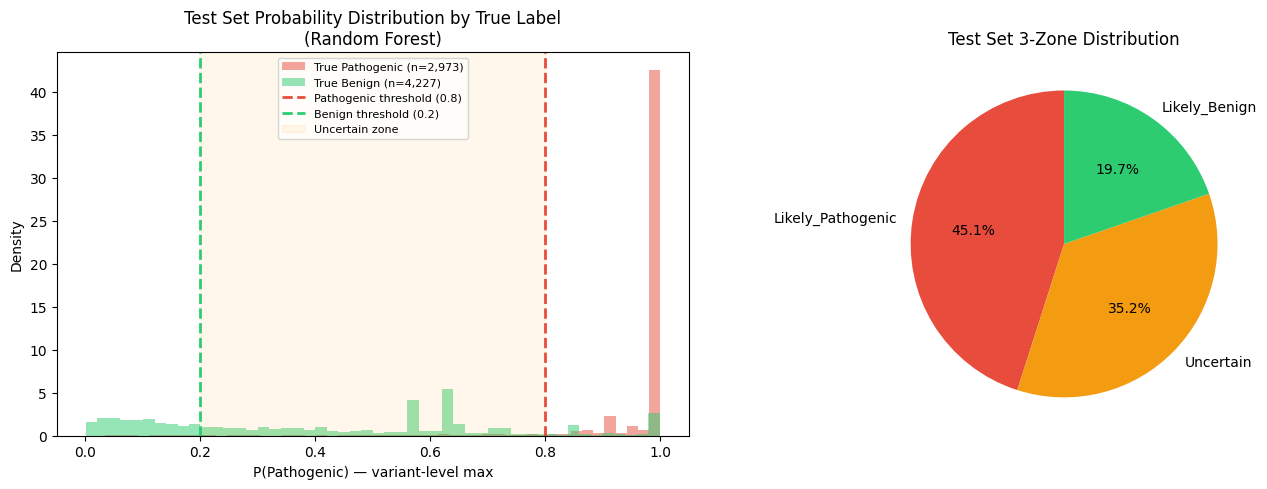

✅ Saved 09b_test_zone_distribution.png

Pathogenic variants with P ≥ 0.70 : 2,841 / 2,973 (95.6%)
(confirms LP/P clustering in 0.7–1.0 range as expected)

VUS INFERENCE
Total VUS variants        : 58,249
  Likely Pathogenic       : 16,211  (27.8%)
  Likely Benign           : 5,282   (9.1%)
  Uncertain (remain VUS)  : 36,756   (63.1%)
  Coverage                : 36.9%


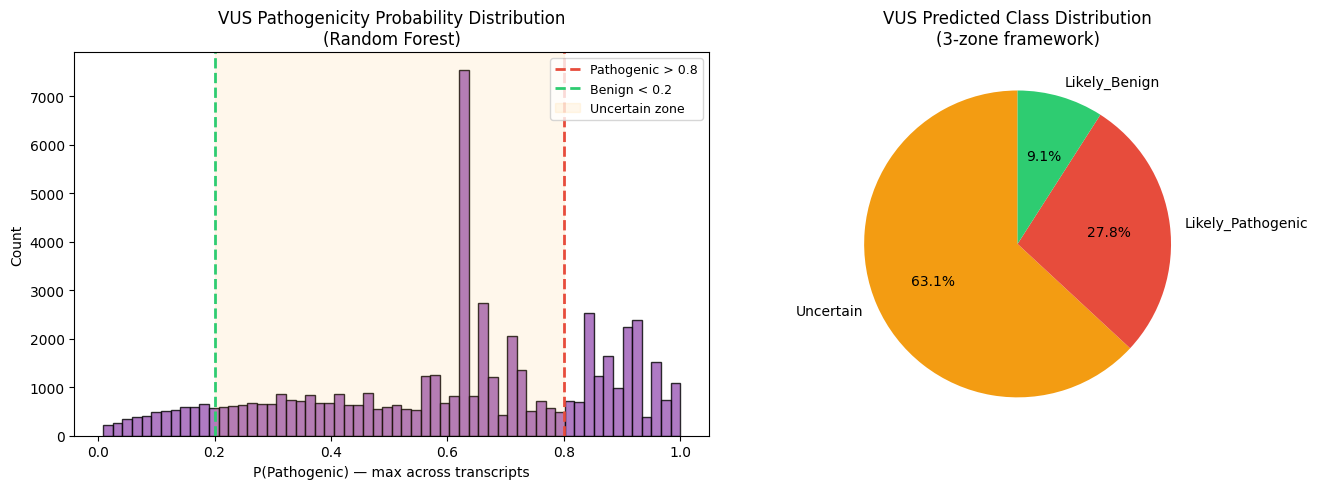

✅ Saved 10_vus_predictions.png


In [18]:
# Apply thresholds to TEST SET (performance validation) 
y_prob_test = best_metrics['variant_df']['y_prob'].values
y_true_test = best_metrics['variant_df']['y_true'].values

def classify_3zone(prob, upper=UPPER_THRESH, lower=LOWER_THRESH):
    if prob > upper:   return 'Likely_Pathogenic'
    elif prob < lower: return 'Likely_Benign'
    else:              return 'Uncertain'

preds_3zone = np.array([classify_3zone(p) for p in y_prob_test])

n_path    = (preds_3zone == 'Likely_Pathogenic').sum()
n_ben     = (preds_3zone == 'Likely_Benign').sum()
n_unc     = (preds_3zone == 'Uncertain').sum()
coverage  = (n_path + n_ben) / len(preds_3zone)

print("=" * 60)
print("TEST SET — 3-ZONE CLASSIFICATION RESULTS")
print("=" * 60)
print(f"  Likely Pathogenic : {n_path:,}  ({n_path/len(preds_3zone)*100:.1f}%)")
print(f"  Likely Benign     : {n_ben:,}   ({n_ben/len(preds_3zone)*100:.1f}%)")
print(f"  Uncertain         : {n_unc:,}   ({n_unc/len(preds_3zone)*100:.1f}%)")
print(f"  Coverage          : {coverage*100:.1f}%  (variants reclassified)")

# Performance on confident predictions only
from sklearn.metrics import classification_report, roc_auc_score
confident_mask  = preds_3zone != 'Uncertain'
confident_preds = (preds_3zone[confident_mask] == 'Likely_Pathogenic').astype(int)
confident_true  = y_true_test[confident_mask]

print(f"\nClassification report (confident zone only — {confident_mask.sum():,} variants):")
print(classification_report(confident_true, confident_preds,
                            target_names=['Benign', 'Pathogenic']))

# Probability distribution plot 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_zone = {'Likely_Pathogenic': '#e74c3c', 'Uncertain': '#f39c12', 'Likely_Benign': '#2ecc71'}

# Histogram with threshold lines
for label_val, color, zone_label in [(1, '#e74c3c', 'Pathogenic'), (0, '#2ecc71', 'Benign')]:
    subset = y_prob_test[y_true_test == label_val]
    axes[0].hist(subset, bins=50, alpha=0.5, color=color,
                 label=f'True {zone_label} (n={len(subset):,})', density=True)

axes[0].axvline(UPPER_THRESH, color='#e74c3c', linestyle='--', lw=2,
                label=f'Pathogenic threshold ({UPPER_THRESH})')
axes[0].axvline(LOWER_THRESH, color='#2ecc71', linestyle='--', lw=2,
                label=f'Benign threshold ({LOWER_THRESH})')
axes[0].axvspan(LOWER_THRESH, UPPER_THRESH, alpha=0.08, color='orange', label='Uncertain zone')
axes[0].set_title(f'Test Set Probability Distribution by True Label\n({best_model_name})')
axes[0].set_xlabel('P(Pathogenic) — variant-level max')
axes[0].set_ylabel('Density')
axes[0].legend(fontsize=8)

# Pie chart of zones
zone_counts = pd.Series(preds_3zone).value_counts()
axes[1].pie(
    zone_counts.values,
    labels=zone_counts.index,
    colors=[colors_zone.get(k, '#cccccc') for k in zone_counts.index],
    autopct='%1.1f%%', startangle=90
)
axes[1].set_title(f'Test Set 3-Zone Distribution')

plt.tight_layout()
plt.savefig('09b_test_zone_distribution.png', dpi=150)
plt.show()
print("✅ Saved 09b_test_zone_distribution.png")

# LP/P clustering check in 0.7-1.0 range 
path_in_high = np.sum((y_true_test == 1) & (y_prob_test >= 0.70))
path_total   = np.sum(y_true_test == 1)
print(f"\nPathogenic variants with P ≥ 0.70 : {path_in_high:,} / {path_total:,} ({path_in_high/path_total*100:.1f}%)")
print("(confirms LP/P clustering in 0.7–1.0 range as expected)")

# Apply thresholds to VUS
print("\n" + "=" * 60)
print("VUS INFERENCE")
print("=" * 60)

y_prob_vus = best_model.predict_proba(X_vus)[:, 1]

df_vus_preds = pd.DataFrame({
    'variant_id'     : df_vus['Uploaded_variation'].values,
    'prob_pathogenic': y_prob_vus
})

df_vus_variant = df_vus_preds.groupby('variant_id').agg(
    prob_pathogenic_max  = ('prob_pathogenic', 'max'),
    prob_pathogenic_mean = ('prob_pathogenic', 'mean'),
    n_transcripts        = ('prob_pathogenic', 'count')
).reset_index()

df_vus_variant['predicted_class'] = df_vus_variant['prob_pathogenic_max'].apply(classify_3zone)

n_vus_path  = (df_vus_variant['predicted_class'] == 'Likely_Pathogenic').sum()
n_vus_ben   = (df_vus_variant['predicted_class'] == 'Likely_Benign').sum()
n_vus_unc   = (df_vus_variant['predicted_class'] == 'Uncertain').sum()
vus_coverage = (n_vus_path + n_vus_ben) / len(df_vus_variant)

print(f"Total VUS variants        : {len(df_vus_variant):,}")
print(f"  Likely Pathogenic       : {n_vus_path:,}  ({n_vus_path/len(df_vus_variant)*100:.1f}%)")
print(f"  Likely Benign           : {n_vus_ben:,}   ({n_vus_ben/len(df_vus_variant)*100:.1f}%)")
print(f"  Uncertain (remain VUS)  : {n_vus_unc:,}   ({n_vus_unc/len(df_vus_variant)*100:.1f}%)")
print(f"  Coverage                : {vus_coverage*100:.1f}%")

# VUS probability histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_vus_variant['prob_pathogenic_max'], bins=60,
             color='#9b59b6', edgecolor='black', alpha=0.8)
axes[0].axvline(UPPER_THRESH, color='#e74c3c', linestyle='--', lw=2,
                label=f'Pathogenic > {UPPER_THRESH}')
axes[0].axvline(LOWER_THRESH, color='#2ecc71', linestyle='--', lw=2,
                label=f'Benign < {LOWER_THRESH}')
axes[0].axvspan(LOWER_THRESH, UPPER_THRESH, alpha=0.08, color='orange', label='Uncertain zone')
axes[0].set_title(f'VUS Pathogenicity Probability Distribution\n({best_model_name})')
axes[0].set_xlabel('P(Pathogenic) — max across transcripts')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=9)

vus_zone_counts = df_vus_variant['predicted_class'].value_counts()
axes[1].pie(
    vus_zone_counts.values,
    labels=vus_zone_counts.index,
    colors=[colors_zone.get(k, '#cccccc') for k in vus_zone_counts.index],
    autopct='%1.1f%%', startangle=90
)
axes[1].set_title('VUS Predicted Class Distribution\n(3-zone framework)')
plt.tight_layout()
plt.savefig('10_vus_predictions.png', dpi=150)
plt.show()
print("✅ Saved 10_vus_predictions.png")

In [19]:
#Save all trained models 
for name, clf in models.items():
    fname = name.lower().replace(' ', '_') + '_model.joblib'
    joblib.dump(clf, fname)
    print(f"✅ {fname}")

joblib.dump(le, 'label_encoder.joblib')
print("✅ label_encoder.joblib")

joblib.dump(best_model, 'best_model.joblib')
with open('best_model_name.txt', 'w') as f:
    f.write(best_model_name)
print(f"✅ best_model.joblib  ({best_model_name})")

# Save threshold config 
threshold_config = {
    'best_model'           : best_model_name,
    'upper_thresh'         : UPPER_THRESH,
    'lower_thresh'         : LOWER_THRESH,
    'method'               : 'Fixed clinical thresholds (Tavtigian et al. 2020)',
    'pathogenic_precision' : float(round(prec_at_upper, 4)),
    'benign_precision'     : float(round(prec_at_lower, 4)),
    'zone_labels': {
        f'> {UPPER_THRESH}'                        : 'Likely_Pathogenic',
        f'{LOWER_THRESH} to {UPPER_THRESH}'        : 'Uncertain',
        f'< {LOWER_THRESH}'                        : 'Likely_Benign'
    },
    'reference' : 'Tavtigian SV et al. Hum Mutat. 2020'
}
with open('threshold_config.json', 'w') as f:
    json.dump(threshold_config, f, indent=2)
print("✅ threshold_config.json")

# Save VUS predictions 
df_vus_variant.to_csv('vus_predictions.csv', index=False)
print(f"✅ vus_predictions.csv  ({len(df_vus_variant):,} variants)")

# Save comparison table 
df_compare.to_csv('model_comparison.csv')
print("✅ model_comparison.csv")

print("\n" + "=" * 60)
print(" COMPLETE SUMMARY")
print("=" * 60)
print(f"  Best model              : {best_model_name}")
print(f"  Variant-level AUC-ROC   : {best_metrics['auc_variant']}")
print(f"  Pathogenic threshold    : > {UPPER_THRESH}  (validated precision: {prec_at_upper:.3f})")
print(f"  Benign threshold        : < {LOWER_THRESH}  (validated precision: {prec_at_lower:.3f})")
print(f"  Test coverage           : {coverage*100:.1f}%")
print(f"  VUS Likely Pathogenic   : {n_vus_path:,}")
print(f"  VUS Likely Benign       : {n_vus_ben:,}")
print(f"  VUS Uncertain           : {n_vus_unc:,}")
print(f"  VUS coverage            : {vus_coverage*100:.1f}%")

✅ logistic_regression_model.joblib
✅ svm_model.joblib
✅ random_forest_model.joblib
✅ xgboost_model.joblib
✅ label_encoder.joblib
✅ best_model.joblib  (Random Forest)
✅ threshold_config.json
✅ vus_predictions.csv  (58,249 variants)
✅ model_comparison.csv

 COMPLETE SUMMARY
  Best model              : Random Forest
  Variant-level AUC-ROC   : 0.961
  Pathogenic threshold    : > 0.8  (validated precision: 0.990)
  Benign threshold        : < 0.2  (validated precision: 0.992)
  Test coverage           : 64.8%
  VUS Likely Pathogenic   : 16,211
  VUS Likely Benign       : 5,282
  VUS Uncertain           : 36,756
  VUS coverage            : 36.9%

  → Next: Notebook 3 — SHAP explainability on best_model.joblib
